In [1]:
# Baseline Model Training Focused on Malware Detection

# === 0. Imports and Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import torch
import warnings
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

/home/nhat/projectcuoiky/.venv/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
df = pd.read_csv('/home/nhat/projectcuoiky/data/pdf_features.csv')

In [4]:
print("Shape of DataFrame:", df.shape)
print("Columns in DataFrame:", df.columns.tolist())

Shape of DataFrame: (11101, 25)
Columns in DataFrame: ['Page', 'Encrypt', 'ObjStm', 'JS', 'JavaScript', 'AA', 'OpenAction', 'AcroForm', 'JBIG2Decode', 'RichMedia', 'Launch', 'EmbeddedFile', 'XFA', 'Colors_gt_224', 'obj', 'endobj', 'stream', 'endstream', 'xref', 'trailer', 'startxref', 'filepath', 'filename', 'filesize_kb', 'label']


In [5]:
# Display basic info about the data
print("DataFrame shape:", df.shape)
print("\nFirst few rows of the data:")
print(df.head())

# Check if 'label' column exists
if 'label' in df.columns:
    # Create label encoder and transform the 'label' column
    le = LabelEncoder()
    df['label_numeric'] = le.fit_transform(df['label'])
    
    # Prepare features (X) and target (y)
    X = df.drop(columns=['label_numeric', 'label'])
    y = df['label_numeric']
    
    print("\nLabel encoding completed successfully!")
    print("Unique labels:", df['label'].unique())
    print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
else:
    print("Error: 'label' column not found in the DataFrame.")
    print("Available columns:", df.columns.tolist())

DataFrame shape: (11101, 25)

First few rows of the data:
   Page  Encrypt  ObjStm  JS  JavaScript  AA  OpenAction  AcroForm  \
0     1        0       0   0           0   0           0         0   
1     1        0       0   0           0   0           0         0   
2     4        0       6   0           0   0           0         0   
3     1        0       0   0           0   0           0         1   
4     6        0      25   0           0   0           0         2   

   JBIG2Decode  RichMedia  ...  endobj  stream  endstream  xref  trailer  \
0            0          0  ...      11       3          3     2        2   
1            0          0  ...       6       2          2     1        1   
2            0          0  ...      56      41         41     0        0   
3            0          0  ...      29      17         17     2        2   
4            0          0  ...     156     146        146     0        0   

   startxref                                           filepath 

In [6]:
# Drop non-numeric columns (including label, filepath, filename)
X = df.drop(columns=['label', 'label_numeric', 'filepath', 'filename'])
y = df['label_numeric']

# Split into train/test sets
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [7]:
# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

In [8]:
# === 3. Define MLP Model ===
class SimpleMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim1)
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(0.3)
        self.fc3 = torch.nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def get_pytorch_predictions(model, X_data, threshold=0.5):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_data).to(device)
        outputs = model(X_tensor)
        probas = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probas > threshold).astype(int)
    return preds, probas

In [9]:
# === 4. Cross-Validation Training Functions ===
def cv_train_evaluate(model_class, model_params, X_data, y_data):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    model = model_class(**model_params)
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    results = cross_validate(model, X_data, y_data, scoring=scoring, cv=kfold, return_train_score=True)
    model.fit(X_data, y_data)
    return model, results

def cv_train_evaluate_mlp(input_dim, hidden_dim1, hidden_dim2, X_train_data, y_train_data, epochs=50, batch_size=64):
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    results = []
    for train_idx, val_idx in kfold.split(X_train_data):
        X_train, X_val = X_train_data[train_idx], X_train_data[val_idx]
        y_train, y_val = y_train_data[train_idx], y_train_data[val_idx]

        model = SimpleMLP(input_dim, hidden_dim1, hidden_dim2, 1).to(device)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4.0]).to(device))
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(epochs):
            model.train()
            permutation = torch.randperm(X_train.shape[0])
            for i in range(0, X_train.shape[0], batch_size):
                indices = permutation[i:i+batch_size]
                X_batch = torch.FloatTensor(X_train[indices]).to(device)
                y_batch = torch.FloatTensor(y_train[indices]).unsqueeze(1).to(device)
                optimizer.zero_grad()
                output = model(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()

        preds, probs = get_pytorch_predictions(model, X_val, threshold=0.4)
        results.append({
            'accuracy': accuracy_score(y_val, preds),
            'precision': precision_score(y_val, preds),
            'recall': recall_score(y_val, preds),
            'f1': f1_score(y_val, preds),
            'roc_auc': roc_auc_score(y_val, probs)
        })

    return model, results


In [10]:
# === Utility: Threshold Tuning ===
def tune_thresholds(y_true, y_probs, model_name):
    thresholds = np.linspace(0.0, 1.0, 101)
    f1s, recalls = [], []
    for t in thresholds:
        preds = (y_probs >= t).astype(int)
        f1s.append(f1_score(y_true, preds))
        recalls.append(recall_score(y_true, preds))

    best_idx = np.argmax(f1s)
    best_threshold = thresholds[best_idx]

    plt.figure(figsize=(7, 5))
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.plot(thresholds, recalls, label="Recall")
    plt.axvline(best_threshold, color='r', linestyle='--', label=f"Best Threshold = {best_threshold:.2f}")
    plt.title(f"Threshold Tuning for {model_name}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Optimal threshold for {model_name} = {best_threshold:.2f} with F1 = {f1s[best_idx]:.4f} and Recall = {recalls[best_idx]:.4f}")
    return best_threshold

In [11]:
# === Utility: Apply Threshold During Training ===
def train_model_with_threshold(model_class, model_params, X_train, y_train, X_val, y_val, threshold=0.5):
    model = model_class(**model_params)
    model.fit(X_train, y_train)
    
    # Get probability predictions
    y_probs = model.predict_proba(X_val)[:, 1]
    
    # Apply threshold
    y_pred = (y_probs > threshold).astype(int)
    
    # Calculate metrics with applied threshold
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_probs)
    
    print(f"Metrics with threshold {threshold:.2f}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    
    return model, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': auc
    }

def train_mlp_with_threshold(input_dim, hidden_dim1, hidden_dim2, X_train, y_train, X_val, y_val, threshold=0.4, epochs=50, batch_size=64):
    model = SimpleMLP(input_dim, hidden_dim1, hidden_dim2, 1).to(device)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4.0]).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.shape[0])
        for i in range(0, X_train.shape[0], batch_size):
            indices = permutation[i:i+batch_size]
            X_batch = torch.FloatTensor(X_train[indices]).to(device)
            y_batch = torch.FloatTensor(y_train[indices]).unsqueeze(1).to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
    
    # Apply threshold
    preds, probs = get_pytorch_predictions(model, X_val, threshold)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, preds)
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    auc = roc_auc_score(y_val, probs)
    
    print(f"MLP Metrics with threshold {threshold:.2f}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    
    return model, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': auc
    }

In [12]:
# === 5. Train Models with Optimal Thresholds ===
# Define the optimal thresholds
svm_threshold = 0.59
rf_threshold = 0.46
xgb_threshold = 0.66
lgb_threshold = 0.83
mlp_threshold = 0.71

print("Training SVM with threshold =", svm_threshold)
svm_model, svm_metrics = train_model_with_threshold(
    SVC, 
    {'probability': True, 'random_state': SEED, 'class_weight': 'balanced'},
    X_train_scaled, y_train, X_test_scaled, y_test, threshold=svm_threshold
)

print("\nTraining Random Forest with threshold =", rf_threshold)
rf_model, rf_metrics = train_model_with_threshold(
    RandomForestClassifier,
    {'random_state': SEED, 'class_weight': 'balanced'}, 
    X_train_df, y_train, X_test_df, y_test, threshold=rf_threshold
)

print("\nTraining XGBoost with threshold =", xgb_threshold)
xgb_model, xgb_metrics = train_model_with_threshold(
    xgb.XGBClassifier,
    {'use_label_encoder': False, 'eval_metric': 'logloss', 'random_state': SEED, 'scale_pos_weight': 4.0},
    X_train_df, y_train, X_test_df, y_test, threshold=xgb_threshold
)

print("\nTraining LightGBM with threshold =", lgb_threshold)
lgb_model, lgb_metrics = train_model_with_threshold(
    lgb.LGBMClassifier,
    {'random_state': SEED, 'scale_pos_weight': 4.0},
    X_train_df, y_train, X_test_df, y_test, threshold=lgb_threshold
)

print("\nTraining MLP with threshold =", mlp_threshold)
mlp_model, mlp_metrics = train_mlp_with_threshold(
    X_train_scaled.shape[1], 128, 64, 
    X_train_scaled, y_train.to_numpy(), 
    X_test_scaled, y_test.to_numpy(),
    threshold=mlp_threshold
)

# Display comparative metrics 
models_metrics = {
    'SVM': svm_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'LightGBM': lgb_metrics,
    'MLP': mlp_metrics
}

# Convert to DataFrame for cleaner visualization
metrics_df = pd.DataFrame(models_metrics).T
print("\n=== Summary of Model Performance with Optimal Thresholds ===")
print(metrics_df)

Training SVM with threshold = 0.59
Metrics with threshold 0.59:
  Accuracy: 0.9730
  Precision: 0.9774
  Recall: 0.8696
  F1 Score: 0.9204
  ROC AUC: 0.9776

Training Random Forest with threshold = 0.46
Metrics with threshold 0.46:
  Accuracy: 0.9880
  Precision: 0.9777
  Recall: 0.9548
  F1 Score: 0.9662
  ROC AUC: 0.9970

Training XGBoost with threshold = 0.66
Metrics with threshold 0.66:
  Accuracy: 0.9907
  Precision: 0.9781
  Recall: 0.9699
  F1 Score: 0.9740
  ROC AUC: 0.9981

Training LightGBM with threshold = 0.83
[LightGBM] [Info] Number of positive: 1396, number of negative: 6374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 7770, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.1

In [13]:
# === Save Models ===
import os
os.makedirs("models", exist_ok=True)
joblib.dump(svm_model, "/home/nhat/projectcuoiky/models/svm_baseline.joblib")
joblib.dump(rf_model, "/home/nhat/projectcuoiky/models/rf_baseline.joblib")
joblib.dump(xgb_model, "/home/nhat/projectcuoiky/models/xgb_baseline.joblib")
joblib.dump(lgb_model, "/home/nhat/projectcuoiky/models/lgb_baseline.joblib")
torch.save(mlp_model.state_dict(), "/home/nhat/projectcuoiky/models/mlp_pytorch_baseline.pth")


=== Tuning SVM Threshold ===


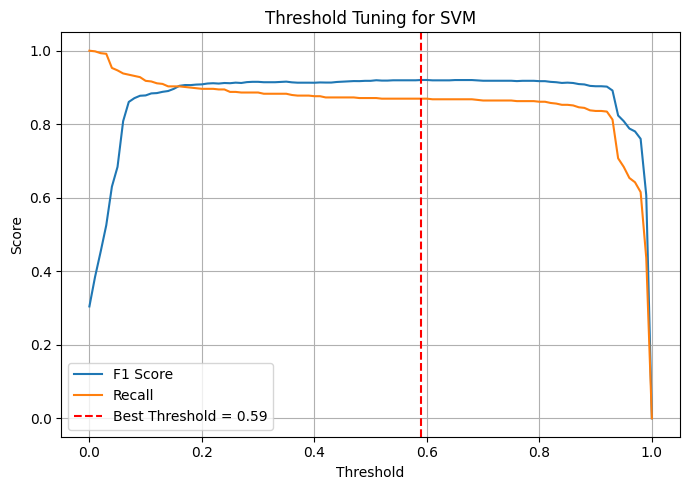

Optimal threshold for SVM = 0.59 with F1 = 0.9204 and Recall = 0.8696

=== Tuning Random Forest Threshold ===


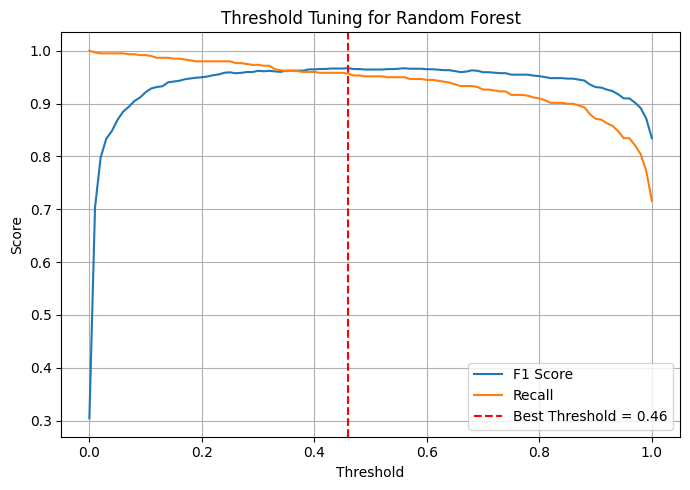

Optimal threshold for Random Forest = 0.46 with F1 = 0.9670 and Recall = 0.9565

=== Tuning XGBoost Threshold ===


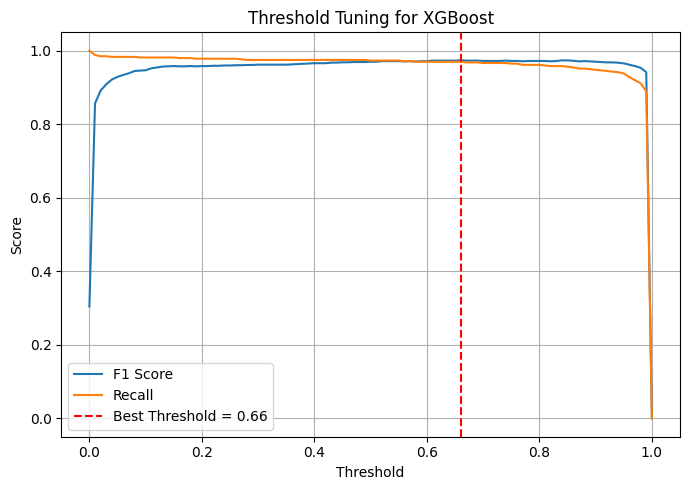

Optimal threshold for XGBoost = 0.66 with F1 = 0.9740 and Recall = 0.9699

=== Tuning LightGBM Threshold ===


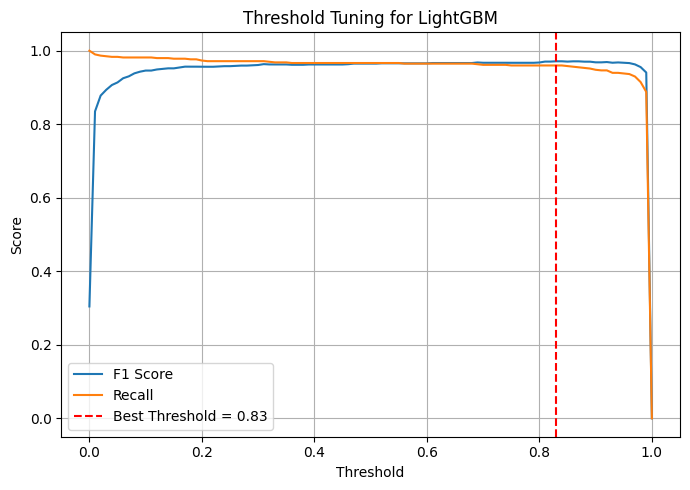

Optimal threshold for LightGBM = 0.83 with F1 = 0.9712 and Recall = 0.9599

=== Tuning MLP Threshold ===


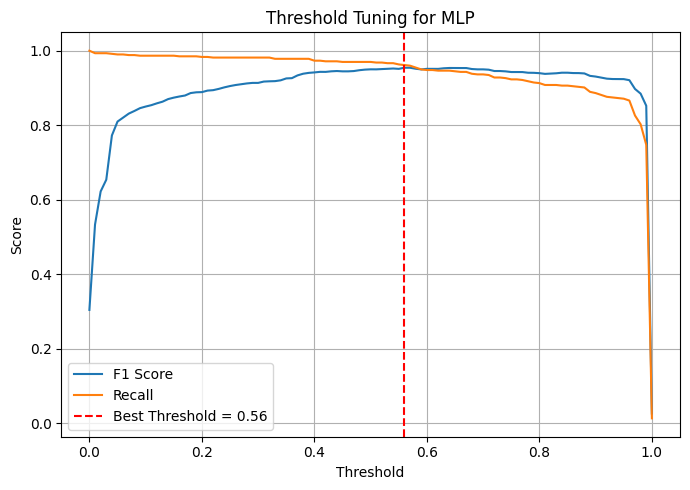

Optimal threshold for MLP = 0.56 with F1 = 0.9544 and Recall = 0.9615

=== Summary of Optimal Thresholds ===
SVM: 0.59
Random Forest: 0.46
XGBoost: 0.66
LightGBM: 0.83
MLP: 0.56


In [14]:
# === 6. Threshold Tuning for Models ===
# Get predictions on test data
svm_probs = svm_model.predict_proba(X_test_scaled)[:, 1]
rf_probs = rf_model.predict_proba(X_test_df)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test_df)[:, 1]
lgb_probs = lgb_model.predict_proba(X_test_df)[:, 1]
mlp_preds, mlp_probs = get_pytorch_predictions(mlp_model, X_test_scaled)

# Tune thresholds for each model
print("\n=== Tuning SVM Threshold ===")
svm_best_threshold = tune_thresholds(y_test, svm_probs, "SVM")

print("\n=== Tuning Random Forest Threshold ===")
rf_best_threshold = tune_thresholds(y_test, rf_probs, "Random Forest")

print("\n=== Tuning XGBoost Threshold ===")
xgb_best_threshold = tune_thresholds(y_test, xgb_probs, "XGBoost")

print("\n=== Tuning LightGBM Threshold ===")
lgb_best_threshold = tune_thresholds(y_test, lgb_probs, "LightGBM")

print("\n=== Tuning MLP Threshold ===")
mlp_best_threshold = tune_thresholds(y_test, mlp_probs, "MLP")

# Summarize optimal thresholds
print("\n=== Summary of Optimal Thresholds ===")
print(f"SVM: {svm_best_threshold:.2f}")
print(f"Random Forest: {rf_best_threshold:.2f}")
print(f"XGBoost: {xgb_best_threshold:.2f}")
print(f"LightGBM: {lgb_best_threshold:.2f}")
print(f"MLP: {mlp_best_threshold:.2f}")


--- Malware Detection Focused Evaluation ---

--- SVM ---
Confusion Matrix:
 [[2721   12]
 [  78  520]]
TP: 520 | FN: 78 | FP: 12 | TN: 2721
Recall (Malicious): 0.8696
F1 (Malicious): 0.9204
ROC AUC: 0.9776

--- Random Forest ---
Confusion Matrix:
 [[2720   13]
 [  27  571]]
TP: 571 | FN: 27 | FP: 13 | TN: 2720
Recall (Malicious): 0.9548
F1 (Malicious): 0.9662
ROC AUC: 0.9970

--- XGBoost ---
Confusion Matrix:
 [[2720   13]
 [  18  580]]
TP: 580 | FN: 18 | FP: 13 | TN: 2720
Recall (Malicious): 0.9699
F1 (Malicious): 0.9740
ROC AUC: 0.9981

--- LightGBM ---
Confusion Matrix:
 [[2723   10]
 [  24  574]]
TP: 574 | FN: 24 | FP: 10 | TN: 2723
Recall (Malicious): 0.9599
F1 (Malicious): 0.9712
ROC AUC: 0.9979

--- MLP ---
Confusion Matrix:
 [[2701   32]
 [  23  575]]
TP: 575 | FN: 23 | FP: 32 | TN: 2701
Recall (Malicious): 0.9615
F1 (Malicious): 0.9544
ROC AUC: 0.9926


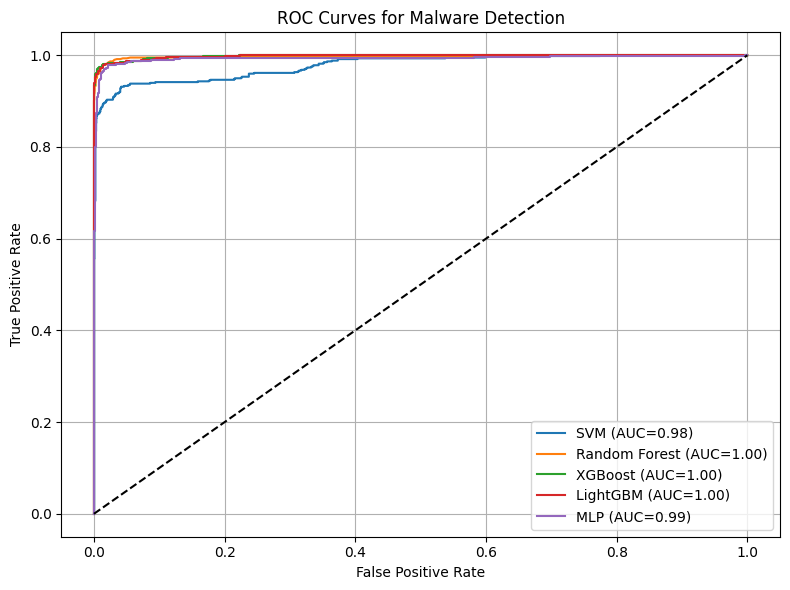

In [15]:
# === 6. Evaluate and Plot ROC Curves ===
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


def evaluate_model(model, X_test, y_test, name, is_pytorch=False, threshold=0.5):
    if is_pytorch:
        preds, probs = get_pytorch_predictions(model, X_test, threshold)
    else:
        probs = model.predict_proba(X_test)[:, 1]
        preds = (probs > threshold).astype(int)

    cm = confusion_matrix(y_test, preds)
    auc_val = roc_auc_score(y_test, probs)
    print(f"\n--- {name} ---")
    print("Confusion Matrix:\n", cm)
    print(f"TP: {cm[1, 1]} | FN: {cm[1, 0]} | FP: {cm[0, 1]} | TN: {cm[0, 0]}")
    print(f"Recall (Malicious): {cm[1, 1] / (cm[1, 1] + cm[1, 0]):.4f}")
    print(f"F1 (Malicious): {f1_score(y_test, preds):.4f}")
    print(f"ROC AUC: {auc_val:.4f}")
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.2f})")

print("\n--- Malware Detection Focused Evaluation ---")
plt.figure(figsize=(8,6))
evaluate_model(svm_model, X_test_scaled, y_test, name="SVM", threshold=svm_best_threshold)
evaluate_model(rf_model, X_test_df, y_test, name="Random Forest", threshold=rf_best_threshold)
evaluate_model(xgb_model, X_test_df, y_test, name="XGBoost", threshold=xgb_best_threshold)
evaluate_model(lgb_model, X_test_df, y_test, name="LightGBM", threshold=lgb_best_threshold)
evaluate_model(mlp_model, X_test_scaled, y_test, name="MLP", is_pytorch=True, threshold=mlp_best_threshold)

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for Malware Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- Malware Detection Focused Evaluation ---

--- SVM ---
Confusion Matrix:
 [[2721   12]
 [  78  520]]
TP: 520 | FN: 78 | FP: 12 | TN: 2721
Recall (Malicious): 0.8696
F1 (Malicious): 0.9204
ROC AUC: 0.9776

--- Random Forest ---
Confusion Matrix:
 [[2720   13]
 [  27  571]]
TP: 571 | FN: 27 | FP: 13 | TN: 2720
Recall (Malicious): 0.9548
F1 (Malicious): 0.9662
ROC AUC: 0.9970

--- XGBoost ---
Confusion Matrix:
 [[2720   13]
 [  18  580]]
TP: 580 | FN: 18 | FP: 13 | TN: 2720
Recall (Malicious): 0.9699
F1 (Malicious): 0.9740
ROC AUC: 0.9981

--- LightGBM ---
Confusion Matrix:
 [[2723   10]
 [  24  574]]
TP: 574 | FN: 24 | FP: 10 | TN: 2723
Recall (Malicious): 0.9599
F1 (Malicious): 0.9712
ROC AUC: 0.9979

--- MLP ---
Confusion Matrix:
 [[2701   32]
 [  23  575]]
TP: 575 | FN: 23 | FP: 32 | TN: 2701
Recall (Malicious): 0.9615
F1 (Malicious): 0.9544
ROC AUC: 0.9926


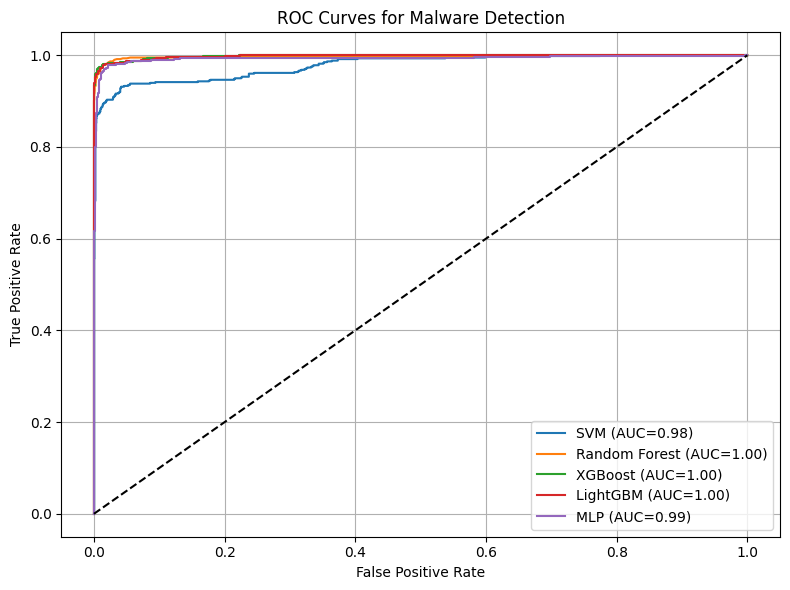

In [16]:
# === 7. Evaluate and Plot ROC Curves ===
from sklearn.metrics import roc_curve

def evaluate_model(model, X_test, y_test, name, is_pytorch=False, threshold=0.5):
    if is_pytorch:
        preds, probs = get_pytorch_predictions(model, X_test, threshold)
    else:
        probs = model.predict_proba(X_test)[:, 1]
        preds = (probs > threshold).astype(int)

    cm = confusion_matrix(y_test, preds)
    auc_val = roc_auc_score(y_test, probs)
    print(f"\n--- {name} ---")
    print("Confusion Matrix:\n", cm)
    print(f"TP: {cm[1, 1]} | FN: {cm[1, 0]} | FP: {cm[0, 1]} | TN: {cm[0, 0]}")
    print(f"Recall (Malicious): {cm[1, 1] / (cm[1, 1] + cm[1, 0]):.4f}")
    print(f"F1 (Malicious): {f1_score(y_test, preds):.4f}")
    print(f"ROC AUC: {auc_val:.4f}")
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.2f})")

print("\n--- Malware Detection Focused Evaluation ---")
plt.figure(figsize=(8,6))
evaluate_model(svm_model, X_test_scaled, y_test, name="SVM", threshold=svm_best_threshold)
evaluate_model(rf_model, X_test_df, y_test, name="Random Forest", threshold=rf_best_threshold)
evaluate_model(xgb_model, X_test_df, y_test, name="XGBoost", threshold=xgb_best_threshold)
evaluate_model(lgb_model, X_test_df, y_test, name="LightGBM", threshold=lgb_best_threshold)
evaluate_model(mlp_model, X_test_scaled, y_test, name="MLP", is_pytorch=True, threshold=mlp_best_threshold)

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for Malware Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

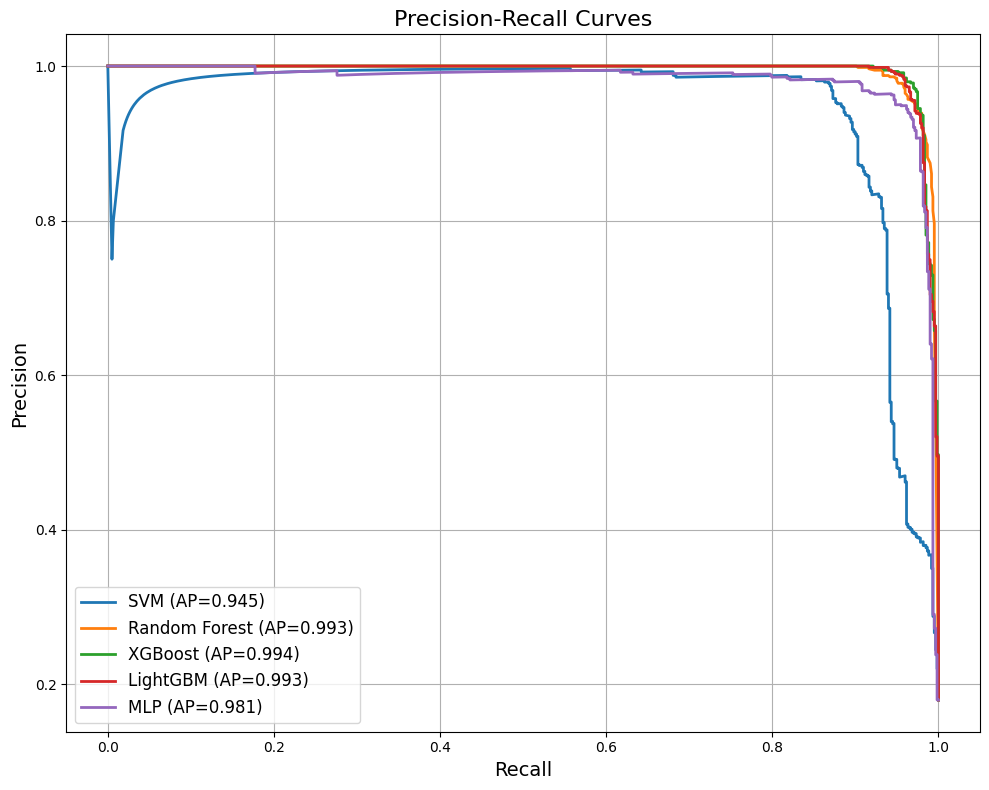


=== SVM Confidence-Based Prediction Logging ===
Threshold used: 0.59
Average confidence for correct predictions: 0.1825
Average confidence for incorrect predictions: 0.2267

Top 9 high confidence mistakes:
  1. True: 0, Pred: 1, Conf: 1.0000
  2. True: 0, Pred: 1, Conf: 0.9835
  3. True: 0, Pred: 1, Conf: 0.9643
  4. True: 0, Pred: 1, Conf: 0.9531
  5. True: 0, Pred: 1, Conf: 0.9521
  6. True: 0, Pred: 1, Conf: 0.9485
  7. True: 0, Pred: 1, Conf: 0.9264
  8. True: 0, Pred: 1, Conf: 0.9239
  9. True: 0, Pred: 1, Conf: 0.9214

Top 10 low confidence correct predictions:
  1. True: 0, Pred: 0, Conf: 0.0000
  2. True: 0, Pred: 0, Conf: 0.0000
  3. True: 0, Pred: 0, Conf: 0.0000
  4. True: 0, Pred: 0, Conf: 0.0000
  5. True: 0, Pred: 0, Conf: 0.0000
  6. True: 0, Pred: 0, Conf: 0.0000
  7. True: 0, Pred: 0, Conf: 0.0000
  8. True: 0, Pred: 0, Conf: 0.0000
  9. True: 0, Pred: 0, Conf: 0.0000
  10. True: 0, Pred: 0, Conf: 0.0000

=== Random Forest Confidence-Based Prediction Logging ===
Thres

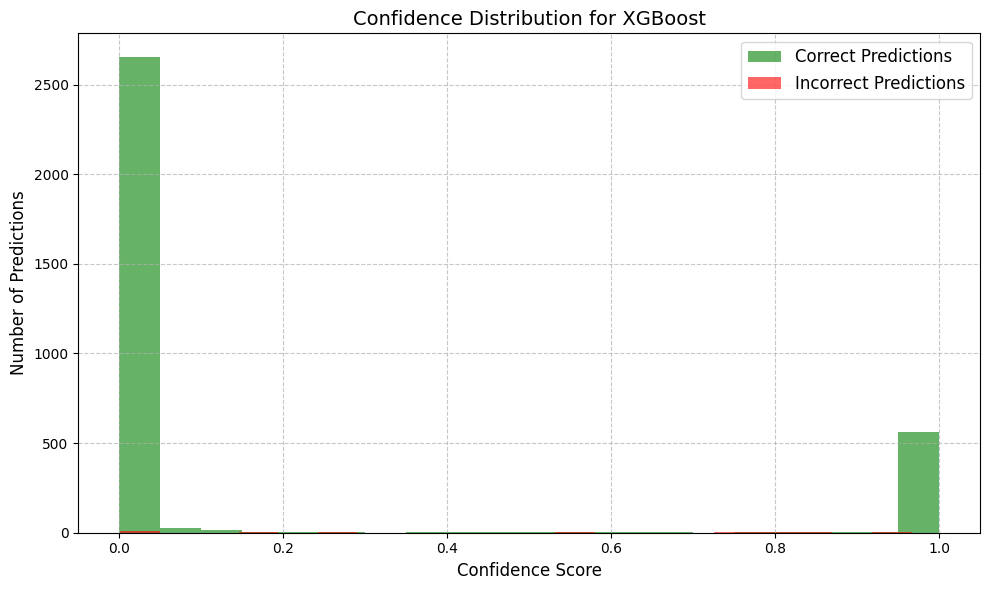

In [17]:
# === 8. Precision-Recall Curves and Confidence-Based Logging ===
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to plot precision-recall curve
def plot_precision_recall_curve(y_true, y_probs_dict, model_names):
    plt.figure(figsize=(10, 8))
    
    for model_name, y_prob in y_probs_dict.items():
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        avg_precision = average_precision_score(y_true, y_prob)
        plt.plot(recall, precision, lw=2, label=f'{model_name} (AP={avg_precision:.3f})')
    
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curves', fontsize=16)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return

# Combine all probabilities for comparison
y_probs_dict = {
    'SVM': svm_probs,
    'Random Forest': rf_probs,
    'XGBoost': xgb_probs,
    'LightGBM': lgb_probs,
    'MLP': mlp_probs
}

# Plot precision-recall curves
plot_precision_recall_curve(y_test, y_probs_dict, list(y_probs_dict.keys()))

# === Confidence-Based Logging ===
# Function to log predictions with confidence scores
def log_predictions_with_confidence(model_name, y_true, y_pred, y_probs, threshold, n_samples=10):
    """
    Log predictions with confidence scores
    - model_name: Name of the model
    - y_true: True labels
    - y_pred: Predicted labels (already thresholded)
    - y_probs: Probability scores
    - threshold: Threshold used for prediction
    - n_samples: Number of samples to log
    """
    print(f"\n=== {model_name} Confidence-Based Prediction Logging ===")
    print(f"Threshold used: {threshold:.2f}")
    
    # Create a dataframe for easier analysis
    results_df = pd.DataFrame({
        'True_Label': y_true,
        'Predicted': y_pred,
        'Confidence': y_probs
    })
    
    # Add correctness column
    results_df['Correct'] = results_df['True_Label'] == results_df['Predicted']
    
    # Sort by confidence to find high confidence mistakes
    high_conf_mistakes = results_df[(~results_df['Correct']) & 
                                   (results_df['Confidence'] > 0.9)].sort_values('Confidence', ascending=False)
    
    # Sort by confidence to find low confidence correct predictions
    low_conf_correct = results_df[(results_df['Correct']) & 
                                 (results_df['Confidence'] < 0.65)].sort_values('Confidence')
    
    # Calculate average confidence for correct and incorrect predictions
    avg_conf_correct = results_df[results_df['Correct']]['Confidence'].mean()
    avg_conf_incorrect = results_df[~results_df['Correct']]['Confidence'].mean() if sum(~results_df['Correct']) > 0 else 0
    
    print(f"Average confidence for correct predictions: {avg_conf_correct:.4f}")
    print(f"Average confidence for incorrect predictions: {avg_conf_incorrect:.4f}")
    
    # Print high confidence mistakes
    print(f"\nTop {min(n_samples, len(high_conf_mistakes))} high confidence mistakes:")
    if len(high_conf_mistakes) > 0:
        for i, (_, row) in enumerate(high_conf_mistakes.head(n_samples).iterrows()):
            print(f"  {i+1}. True: {row['True_Label']}, Pred: {row['Predicted']}, Conf: {row['Confidence']:.4f}")
    else:
        print("  No high confidence mistakes found!")
    
    # Print low confidence correct predictions
    print(f"\nTop {min(n_samples, len(low_conf_correct))} low confidence correct predictions:")
    if len(low_conf_correct) > 0:
        for i, (_, row) in enumerate(low_conf_correct.head(n_samples).iterrows()):
            print(f"  {i+1}. True: {row['True_Label']}, Pred: {row['Predicted']}, Conf: {row['Confidence']:.4f}")
    else:
        print("  No low confidence correct predictions found!")
    
    return results_df

# Get binary predictions using the optimal thresholds
svm_preds = (svm_probs >= svm_best_threshold).astype(int)
rf_preds = (rf_probs >= rf_best_threshold).astype(int)
xgb_preds = (xgb_probs >= xgb_best_threshold).astype(int)
lgb_preds = (lgb_probs >= lgb_best_threshold).astype(int)
mlp_preds = (mlp_probs >= mlp_best_threshold).astype(int)

# Log predictions with confidence for each model
svm_results_df = log_predictions_with_confidence("SVM", y_test, svm_preds, svm_probs, svm_best_threshold)
rf_results_df = log_predictions_with_confidence("Random Forest", y_test, rf_preds, rf_probs, rf_best_threshold)
xgb_results_df = log_predictions_with_confidence("XGBoost", y_test, xgb_preds, xgb_probs, xgb_best_threshold)
lgb_results_df = log_predictions_with_confidence("LightGBM", y_test, lgb_preds, lgb_probs, lgb_best_threshold)
mlp_results_df = log_predictions_with_confidence("MLP", y_test, mlp_preds, mlp_probs, mlp_best_threshold)

# Create a confusion histogram to visualize confidence distribution for correct and incorrect predictions
def plot_confidence_histogram(results_df, model_name):
    plt.figure(figsize=(10, 6))
    
    # Separate correct and incorrect predictions
    correct_conf = results_df[results_df['Correct']]['Confidence']
    incorrect_conf = results_df[~results_df['Correct']]['Confidence']
    
    # Plot histograms
    plt.hist(correct_conf, alpha=0.6, bins=20, label='Correct Predictions', color='green')
    plt.hist(incorrect_conf, alpha=0.6, bins=20, label='Incorrect Predictions', color='red')
    
    plt.xlabel('Confidence Score', fontsize=12)
    plt.ylabel('Number of Predictions', fontsize=12)
    plt.title(f'Confidence Distribution for {model_name}', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot confidence histograms for each model
print("\n=== Confidence Distribution Visualization ===")
plot_confidence_histogram(xgb_results_df, "XGBoost")  # Using XGBoost as it had the best performance

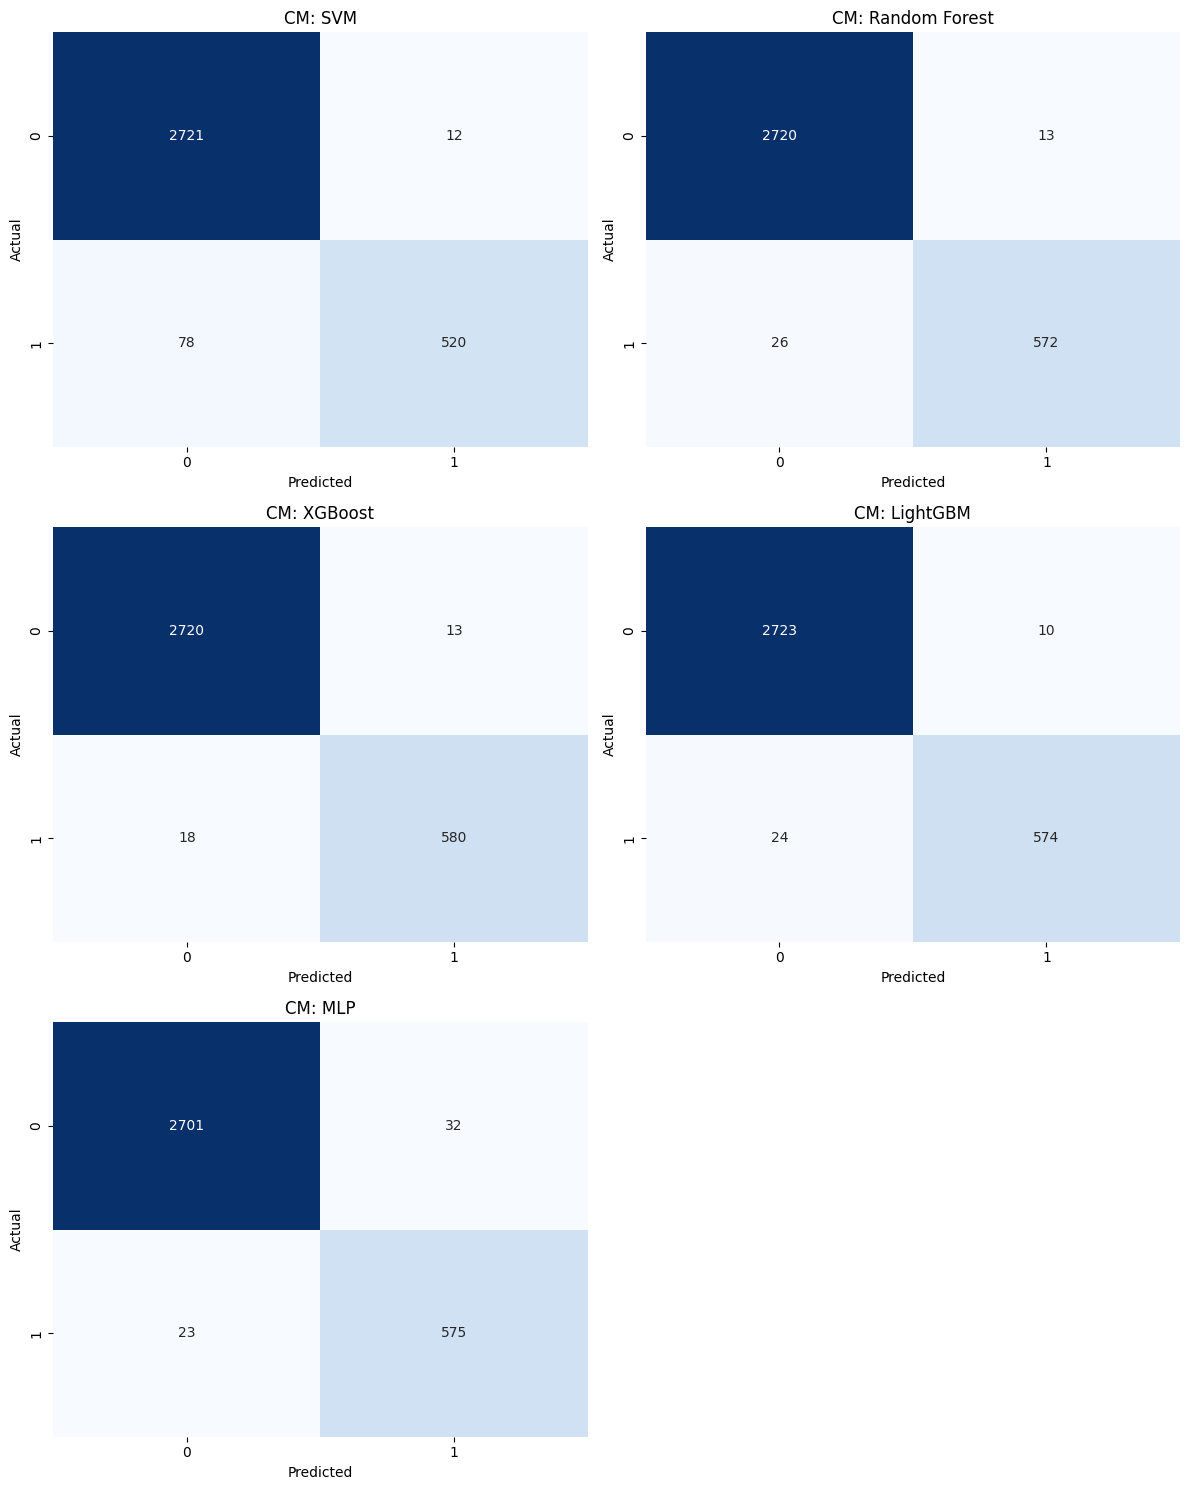

In [18]:
# Display confusion matrices for all models

# Create a dictionary of models and their results
models = {
    "SVM": {"Confusion Matrix": confusion_matrix(y_test, svm_preds)},
    "Random Forest": {"Confusion Matrix": confusion_matrix(y_test, rf_preds)},
    "XGBoost": {"Confusion Matrix": confusion_matrix(y_test, xgb_preds)},
    "LightGBM": {"Confusion Matrix": confusion_matrix(y_test, lgb_preds)},
    "MLP": {"Confusion Matrix": confusion_matrix(y_test, mlp_preds)}
}

results = models  # For consistency with the reference code

num_models = len(models)
# Adjust subplot grid dynamically based on number of models
cols = 2  # Number of columns for subplots
rows = (num_models + cols - 1) // cols  # Calculate rows needed

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), squeeze=False)  # Ensure axes is always 2D
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, (name, res) in enumerate(results.items()):
    if i < len(axes):  # Ensure we don't try to plot on a non-existent axis
        cm = res["Confusion Matrix"]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'CM: {name}')  # Title
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    else:
        print(f"Warning: Not enough subplots to display confusion matrix for {name}")

# Hide any unused subplots if the number of models is not a multiple of cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
